In [1]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# Only Training data is used

df_FaultFree = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_Faulty_Training.RData')['faulty_training']

In [5]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


# Scale the dataset

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()

sc.fit(df_FaultFree.iloc[:,3:])


StandardScaler()

# Select a subset of the Entire Dataset

In [7]:
# Select a subset of the data from simulation runs 1 to 10, and filter out fault numbers 9 and 15
reduced_data = DF.loc[(DF['simulationRun'] >= 1) & (DF['simulationRun'] <= 10)]
reduced_data = reduced_data[reduced_data['faultNumber'] != 9]
reduced_data = reduced_data[reduced_data['faultNumber'] != 15]

# Apply scaling transformation to selected features of the filtered dataset
X = sc.transform(reduced_data[reduced_data['sample'] > 20].iloc[:, 3:])

# Extract the fault numbers that occur after the 20th sample
Y = reduced_data[reduced_data['sample'] > 20]['faultNumber'].values

# Add a random number coloumn to X as a control feature

In [8]:
control_col = np.random.random(len(X)).reshape(-1,1)
X = np.hstack((X,control_col ))

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
x_train.shape

(72960, 53)

# Random Forest Feature Importance

In [26]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(random_state=0)

In [27]:
RF_clf.fit(x_train,y_train)
RF_clf.score(x_train,y_train)

1.0

In [28]:
RF_clf.score(x_test,y_test)

0.8103618421052632

# Create bar plot for RF feature importance

In [92]:
# get feature importances
importances = RF_clf.feature_importances_
feature_name = np.array(reduced_data.columns[3:])
feature_name = np.append(feature_name,"control_feature")

# Create a DataFrame from the two arrays
feature_importance = pd.DataFrame({'feature_name': feature_name, 'importances': importances})

# Sort the DataFrame by importances in descending order
feature_importance = feature_importance.sort_values('importances', ascending=False)

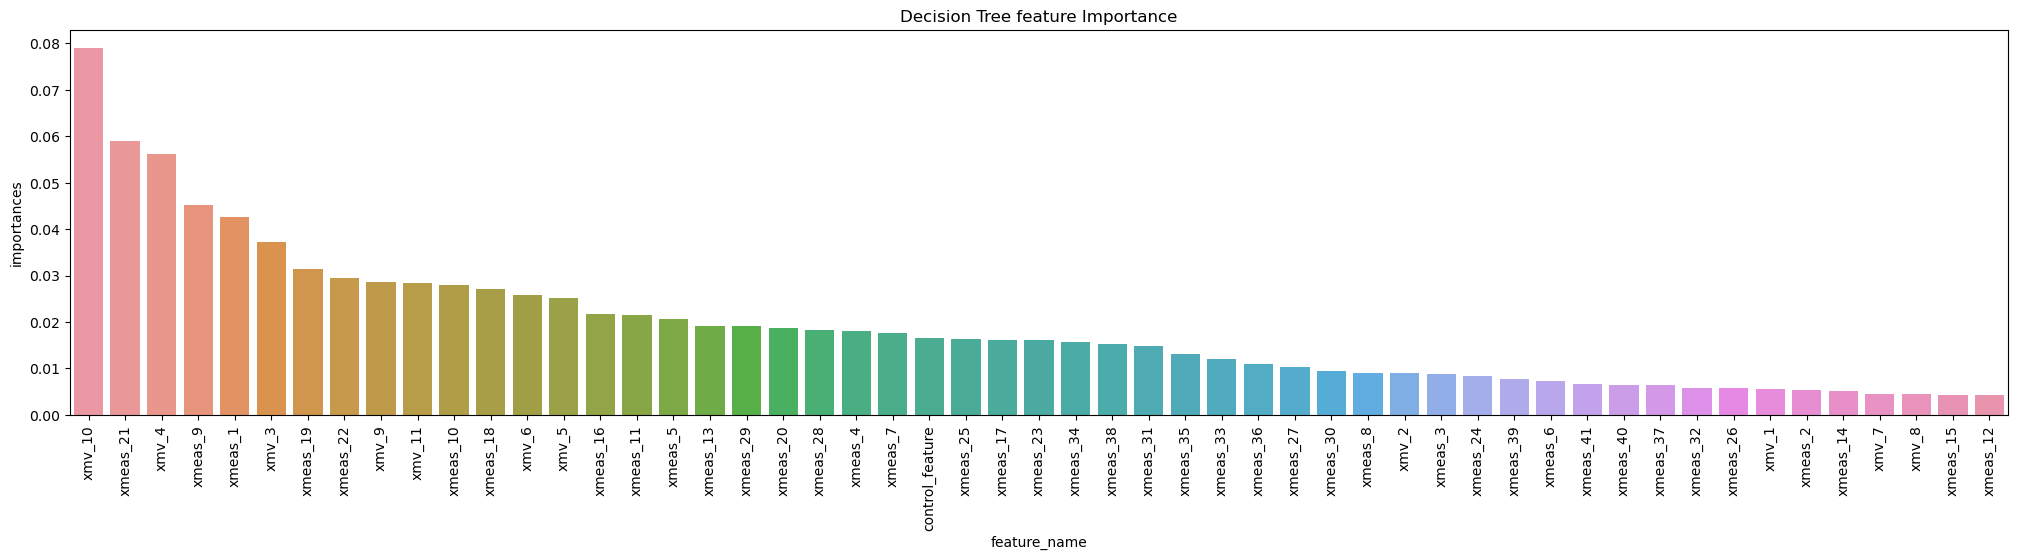

In [93]:
plt.figure(figsize=(25, 5))
sns.barplot(x=feature_importance.feature_name , y=feature_importance.importances)
plt.title(f"RAndom Forest feature Importance")
plt.xticks(rotation=90)
plt.show()

# Permutaion Feature Importance on this Random Forest

In [94]:
from sklearn.inspection import permutation_importance

result = permutation_importance(RF_clf, x_test, y_test, n_repeats=5)

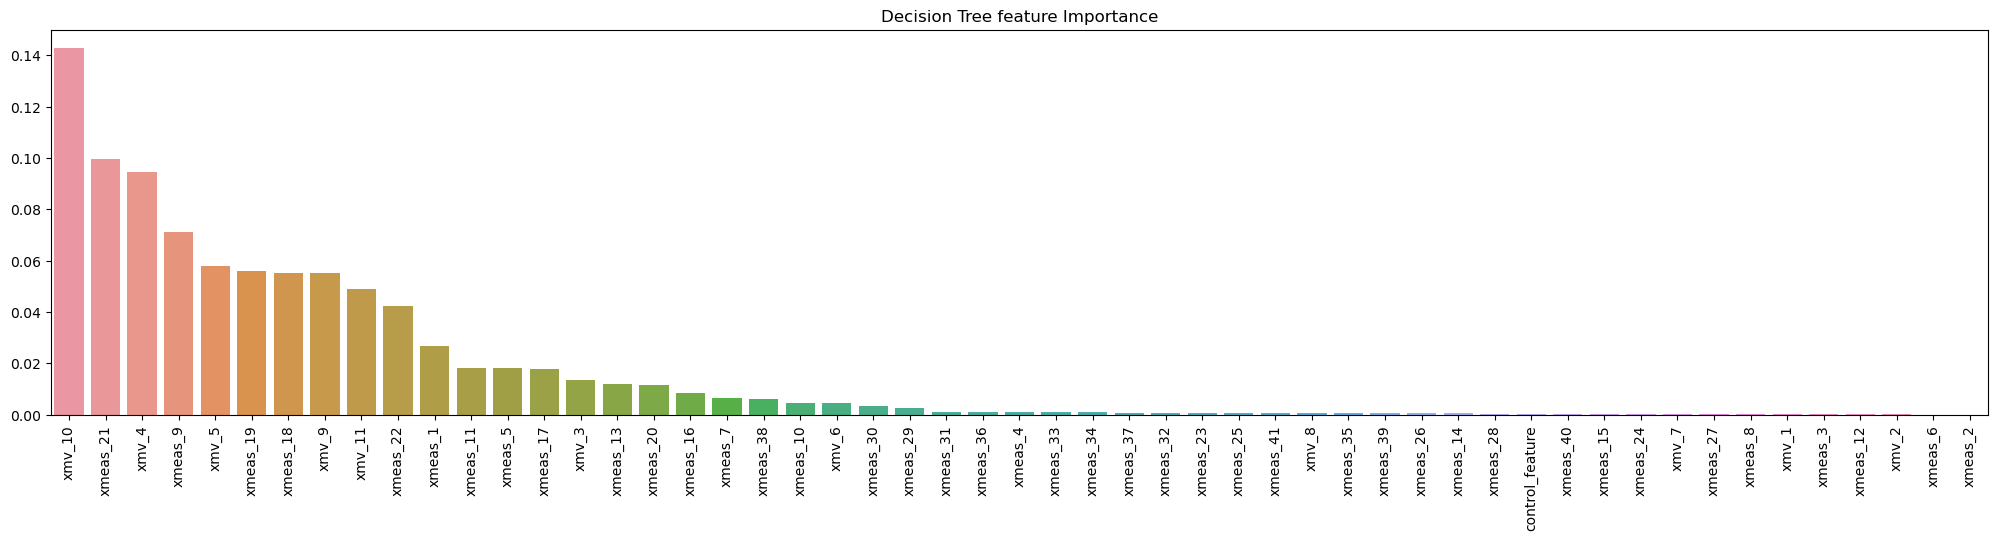

In [106]:
feature_name = np.array(reduced_data.columns[3:])
feature_name = np.append(feature_name,"control_feature")

forest_importances = pd.Series(result.importances_mean, index=feature_name)
forest_importances = forest_importances.abs().sort_values(ascending=False)

plt.figure(figsize=(25, 5))
sns.barplot(x=forest_importances.index , y=forest_importances.values)
plt.title(f"Permutation feature Importance")
plt.xticks(rotation=90)
plt.show()